In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import chain
from matplotlib import pyplot as plt
from matplotlib import dates
from datetime import datetime
from matplotlib.pyplot import figure
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

In [ ]:
df_pln_usd = pd.read_csv("drive/MyDrive/Engineer's Project/output_pln_usd.csv")
df_eur_pln = pd.read_csv("drive/MyDrive/Engineer's Project/output_eur_pln.csv")
df_eur_usd = pd.read_csv("drive/MyDrive/Engineer's Project/output_eur_usd_trimmed.csv")

In [ ]:
date_pln_usd = pd.to_datetime(df_pln_usd["Date"])
date_eur_pln = pd.to_datetime(df_eur_pln["Date"])
date_eur_usd = pd.to_datetime(df_eur_usd["Date"])

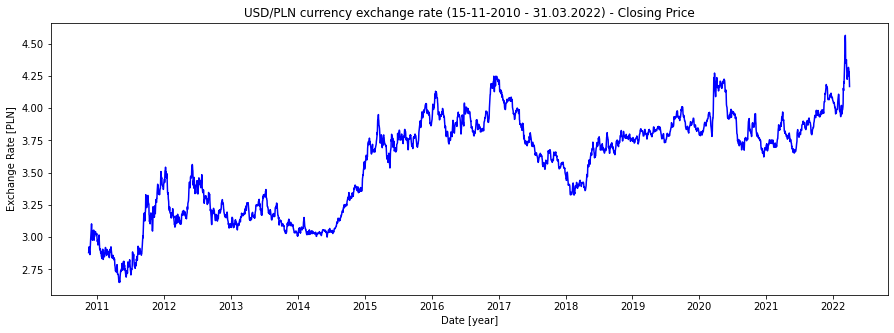

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
ax = plt.gca()
#ax.xaxis.set_major_locator(dates.MonthLocator(interval=12))
ax.xaxis.set_major_locator(dates.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
plt.xlabel("Date [year]")
plt.ylabel("Exchange Rate [PLN]")
plt.title("USD/PLN currency exchange rate (15-11-2010 - 31.03.2022) - Closing Price")
plt.plot(date_pln_usd,df_pln_usd["Closing"], 'b-')
images_dir = "drive/MyDrive/Engineer's Project/figures"
plt.savefig(f"{images_dir}/usd_pln.png")
plt.show()

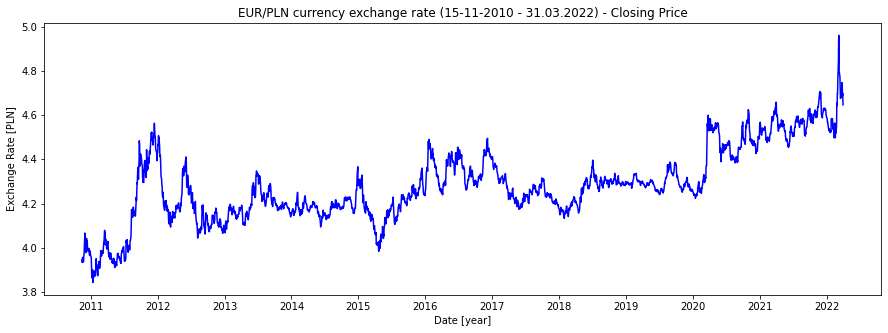

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
ax = plt.gca()
ax.xaxis.set_major_locator(dates.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
plt.xlabel("Date [year]")
plt.ylabel("Exchange Rate [PLN]")
plt.title("EUR/PLN currency exchange rate (15-11-2010 - 31.03.2022) - Closing Price")
plt.plot(date_eur_pln,df_eur_pln["Closing"], 'b-')
images_dir = "drive/MyDrive/Engineer's Project/figures"
plt.savefig(f"{images_dir}/eur_pln.png")
plt.show()

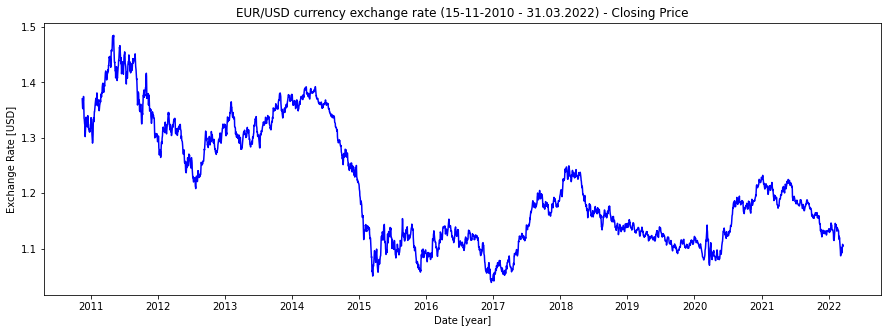

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
ax = plt.gca()
ax.xaxis.set_major_locator(dates.YearLocator(1,1,1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
plt.xlabel("Date [year]")
plt.ylabel("Exchange Rate [USD]")
plt.title("EUR/USD currency exchange rate (15-11-2010 - 31.03.2022) - Closing Price")
plt.plot(date_eur_usd,df_eur_usd["Closing"], 'b-')
images_dir = "drive/MyDrive/Engineer's Project/figures"
plt.savefig(f"{images_dir}/eur_usd.png")
plt.show()

In [ ]:
model = tf.keras.models.load_model("drive/MyDrive/Engineer's Project/longer_prediction.h5")

In [ ]:
df_pln_usd.pop('usa_cpi')
df_pln_usd.pop('pol_cpi')
df_pln_usd.pop('usa_inter')
df_pln_usd.pop('pol_inter')
df_pln_usd.pop('Date')

0       2010.11.15
1       2010.11.16
2       2010.11.17
3       2010.11.18
4       2010.11.19
           ...    
3537    2022.03.27
3538    2022.03.28
3539    2022.03.29
3540    2022.03.30
3541    2022.03.31
Name: Date, Length: 3542, dtype: object

In [ ]:
scaler = MinMaxScaler()
df_numpy = df_pln_usd.to_numpy() 
scaler = scaler.fit(df_numpy[2000:3001])
df_scalled = scaler.transform(df_numpy)
df_scalled = pd.DataFrame(df_scalled, columns=[
  'Opening', 'High', 'Low', 'Closing','Momentum', 'Range', 'ohlc'])

In [ ]:
df_train = df_scalled[2200:3001]
df_game = df_scalled[3001:]

In [ ]:
lookback = 30 #30 for longer; 15
step = 1
delay = 30 #30 for longer; 0
batch_size = 128

In [ ]:
float_data = np.array(df_scalled).astype('float32')
float_train_data = np.array(df_train).astype('float32')
float_game_data = np.array(df_game).astype('float32')

In [ ]:
len(float_game_data)

541

In [ ]:
correct_peaks = 0
value = 0
predicted_values = []
actual_values = []
for i in range(0, 541):
  last15 = float_train_data[-lookback:]
  last15 = last15.reshape(1,15,7)
  prediction = model.predict(last15)
  predicted_values.append(prediction[0][0])
  last_val = last15[0][lookback-1][3]
  actual_val = float_game_data[0][3]
  actual_values.append(actual_val)
  if((prediction > last_val) and (actual_val > last_val)):
    correct_peaks+=1
    value +=  100 *(actual_val - last_val)
  elif((prediction < last_val) and (actual_val < last_val)):
    correct_peaks+=1
    value += 100 * (last_val - actual_val)
  else:
    value -= 100 * abs(actual_val - last_val)
  float_train_data = np.vstack((float_train_data, float_game_data[0]))
  float_game_data = np.delete(float_game_data, 0, 0)

1/1 [==============================] - 0s 16ms/step


In [ ]:
len(predicted_values)

541

In [ ]:
len(actual_values)

541

In [ ]:
predicted_values

In [ ]:
out = predicted_values[538] - scaler.min_[3]
out = out / scaler.scale_[3]
print(out)

4.245516453732046


In [ ]:
out2 = actual_values[538] - scaler.min_[3]
out2 = out2 / scaler.scale_[3]
print(out2)

4.281359649352832


In [ ]:
scaled_predicted = []
scaled_actual = []
for val in predicted_values:
  val_ = val - scaler.min_[3]
  val_ /= scaler.scale_[3]
  scaled_predicted.append(val_)

for val in actual_values:
  val_ = val - scaler.min_[3]
  val_ /= scaler.scale_[3]
  scaled_actual.append(val_)

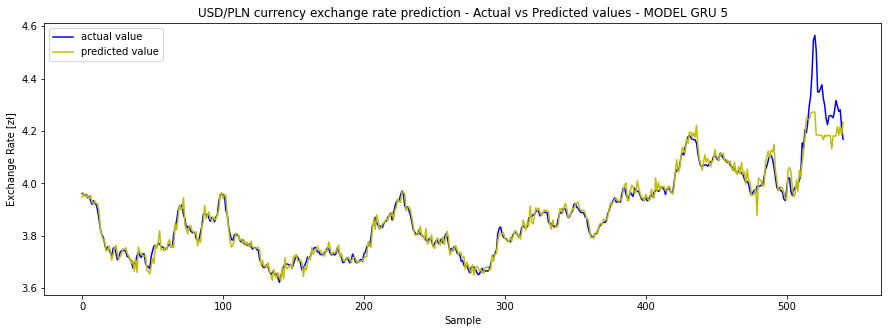

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
ax = plt.gca()
plt.xlabel("Sample")
plt.ylabel("Exchange Rate [zł]")
plt.title("USD/PLN currency exchange rate prediction - Actual vs Predicted values - MODEL GRU 5")
plt.plot(scaled_actual, 'b-', label="actual value")
plt.plot(scaled_predicted, 'y-', label="predicted value")
plt.legend(loc="upper left")
images_dir = "drive/MyDrive/Engineer's Project/figures"
plt.savefig(f"{images_dir}/usd_pln_prediction_GRU_5.png")
plt.show()

In [ ]:
sum = 0
for i in range(0, 541):
  res = abs(scaled_predicted[i] - scaled_actual[i])
  sum += res
print(sum/541)

0.02028472473198234


In [ ]:
correct_picks = 0
value = 0
predicted_values = []
actual_values = []
for i in range(541-30): #len(float_train_data - lookback - delay
  if len(float_game_data) <= 30:
    break
  last = float_train_data[-lookback:]
  last = last.reshape(1,30,7)
  prediction = model.predict(last)
  predicted_values.append(prediction[0][0])
  last_val = last[0][lookback-1][3]
  actual_val = float_game_data[29][3]
  actual_values.append(actual_val)
  if((prediction > last_val) and (actual_val > last_val)):
    correct_picks+=1
    value += 100 * (actual_val - last_val)
  elif((prediction < last_val) and (actual_val < last_val)):
    correct_picks+=1
    value += 100 * (last_val - actual_val)
  else:
    value -= 100 * abs(actual_val - last_val)
  float_train_data = np.vstack((float_train_data, float_game_data[0]))
  float_game_data = np.delete(float_game_data, 0, 0)

1/1 [==============================] - 0s 14ms/step


In [ ]:
scaled_predicted = []
scaled_actual = []
for val in predicted_values:
  val_ = val - scaler.min_[3]
  val_ /= scaler.scale_[3]
  scaled_predicted.append(val_)

for val in actual_values:
  val_ = val - scaler.min_[3]
  val_ /= scaler.scale_[3]
  scaled_actual.append(val_)

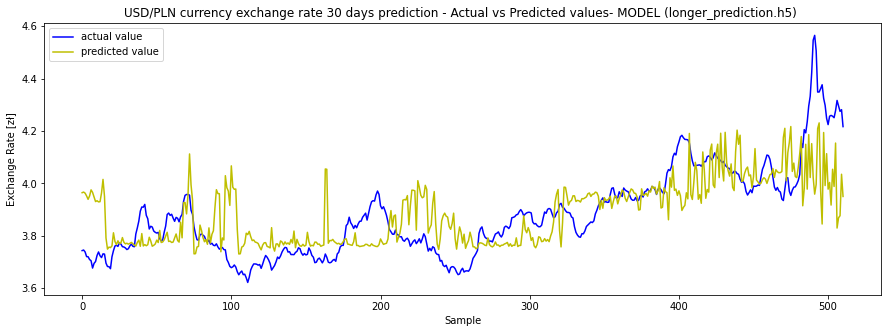

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
ax = plt.gca()
plt.xlabel("Sample")
plt.ylabel("Exchange Rate [zł]")
plt.title("USD/PLN currency exchange rate 30 days prediction - Actual vs Predicted values- MODEL (longer_prediction.h5) ")
plt.plot(scaled_actual, 'b-', label="actual value")
plt.plot(scaled_predicted, 'y-', label="predicted value")
plt.legend(loc="upper left")
images_dir = "drive/MyDrive/Engineer's Project/figures"
plt.savefig(f"{images_dir}/usd_pln_prediction_longer_prediction.png")
plt.show()

In [ ]:
sum = 0
for i in range(0, 511):
  res = abs(scaled_predicted[i] - scaled_actual[i])
  sum += res
print(sum/541)

0.09226201391329178
